In [11]:
import jieba
import pandas as pd
import numpy as np
import re

In [4]:
import os as os
os.chdir('D:\\ETH\\Robut')
os.getcwd()

'D:\\ETH\\Robut'

In [5]:
data = pd.read_csv('data2')

Sentence Tokenization

In [7]:
def sentence_tokenizer(paragraph):
    if type(paragraph)== str:
        for sent in re.findall(u'[^!?。\.\!\?]+[!?。\.\!\?]?', paragraph, flags=re.U):
            yield sent


In [52]:
sent = [list(sentence_tokenizer(data.iloc[x,0])) for x in range(0,data.shape[0])]

#list(sentence_tokenizer(data.iloc[5,0]))

Word Tokenization 

In [8]:
def word_tokenizer(paragraph):
    if type(paragraph)== str:
        words =  jieba.cut(paragraph, cut_all=False)
        return [i for i in words]

In [9]:
words = jieba.cut(data.iloc[0,0], cut_all=False)

In [10]:
word_token = [word_tokenizer(data.iloc[x,0]) for x in np.random.choice(data.shape[0], 100000, replace=False)]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Luyang\AppData\Local\Temp\jieba.cache
Loading model cost 1.742 seconds.
Prefix dict has been built succesfully.


In [11]:
with open('stopwords-zh.txt', 'r', encoding= 'UTF-8') as f:
    stopwords =  f.read().splitlines() 

In [27]:
female_name = ['丽','琳','美','艳', '敏', '丽', '静','妮','秀英']
male_name = ['伟','刚','强','磊', '亮','军','勇','杰','凯']

In [13]:
for i in ['\u3000','\ue40c']:
    stopwords.append(i)
stopwords.append('记者')
stopwords.append('本报')
stopwords.append('“')
stopwords.append('”')
stopwords.append('作者') 
stopwords.append('人民网')
stopwords.append('中新社')
stopwords.append('中新网')
stopwords.append('快讯')
stopwords.append('分社')
stopwords.remove('他')
stopwords.remove('她')
stopwords.remove('他们')
stopwords.remove('她们')
stopwords.remove('它')
stopwords.remove('它们')


In [14]:
word_token1 = [x for x in word_token if type(x)==list]

In [15]:
word_token2=[]
for i in range(0,len(word_token1)):
    temp = []
    for j in range(0,len(word_token1[i])):
        if word_token1[i][j] not in stopwords:
            temp.append(word_token1[i][j])
    word_token2.append(temp) 

In [17]:
import pickle
with open('C:\\Users\\Luyang\\word_token2_new.pkl', 'wb') as f:
    pickle.dump(word_token2, f)

Build Wordvec model

In [9]:
import gensim
from gensim.models import Word2Vec

In [10]:
model = Word2Vec(word_token2, min_count=10, size=500, window=5)


In [11]:
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))


Number of word vectors: 85647


In [12]:
normalized_word_vec = {}
#word_vectors = model.wv
for w in model.wv.vocab:
  vec = word_vectors[w]
  vector_length = np.sqrt(sum([x*x for x in vec]))
  normalized_word_vec[w] = [v/vector_length for v in vec]

In [28]:
male = ['男', '男人', '男孩', '小伙', '男子', '男生', '男同学', '少年','大爷', '先生', '男士','他','他们']
female = ['女', '女人', '女孩', '姑娘', '女子', '女生', '女同学', '少女','大妈','女士', '女士','她','她们']

In [29]:
male_w_name=np.concatenate((male,male_name))
female_w_name = np.concatenate((female,female_name))

In [30]:
diff_all = []
for i,j in list(zip(male_w_name,female_w_name)):
    diff=np.array(normalized_word_vec[i])-np.array(normalized_word_vec[j])
    diff_all.append(diff.reshape(500,1))

In [31]:
diff_all1=np.array(diff_all).reshape(500,len(male_w_name))

In [32]:
sex_dim = np.mean(diff_all1,1).reshape(1,-1)
sex_dim.shape

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

In [28]:
cosine_similarity(np.array(sex_dim).reshape(1,500), word_vectors['消防员'].reshape(1,-1))[0][0]

0.002116151711306226

In [17]:
cossim_dict={}

In [34]:
#largest = 0
for i in model.wv.vocab:
    sim = cosine_similarity(sex_dim, word_vectors[i].reshape(1,-1))[0][0]
    cossim_dict[i]=sim

In [19]:
from collections import Counter

In [36]:
occupations = ['医生','护士','教师','警察','主持人','运动员','消防员','演员','专家','教授','工程师','老板', '厨师','会计','画家','经理','公务员', '服务员']
cossim_dict_occup={}
for i in occupations:
    sim = cosine_similarity(np.array(sex_dim).reshape(1,500), np.array(normalized_word_vec[i]).reshape(1,-1))[0][0]
    cossim_dict_occup[i]=sim

In [34]:
sorted(cossim_dict_occup.items(), key = lambda kv:(kv[1], kv[0]))

[('老板', -0.06263233278571352),
 ('主持人', -0.03163811472394054),
 ('服务员', -0.03067473225548962),
 ('演员', -0.01352458944913593),
 ('警察', -0.009985231253086063),
 ('厨师', -0.009720219806741457),
 ('经理', -0.0034623391498119363),
 ('消防员', 0.002116151711306226),
 ('教师', 0.011812175921334406),
 ('会计', 0.013329878247190001),
 ('工程师', 0.026252001907350345),
 ('画家', 0.026668260552129612),
 ('专家', 0.03087272963604419),
 ('医生', 0.03665087223235616),
 ('教授', 0.036700209393207804),
 ('护士', 0.04423485847057537),
 ('运动员', 0.05528601932751853),
 ('公务员', 0.06567212113554971)]

In [82]:
word_label = occupations
arr = []
for w in word_label:
    arr.append(normalized_word_vec[w])
    
occupations_E =   ['Doctor','Nurse','Teacher','Policeman','Host','Athlete','Fireman','Actor','Expert','Professor','Engineer','Boss', 'Chef','Accountant','Painter','Manager','Civil Servant', 'Waiter']   

In [83]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)

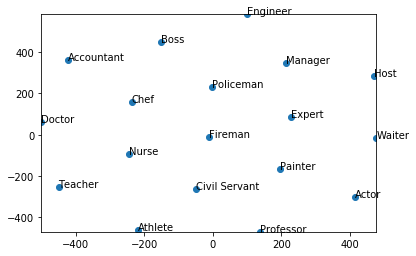

In [84]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
    # display scatter plot
plt.scatter(x_coords, y_coords)

for label, x, y in zip(occupations_E, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(x_coords.min()+0.001, x_coords.max()+0.001)
plt.ylim(y_coords.min()+0.001, y_coords.max()+0.001)
plt.show()

In [52]:
def word_algebra(add=[], subtract=[], topn=1):
    """
    combine the vectors associated with the words provided
    in add= and subtract=, look up the topn most similar
    terms to the combined vector, and print the result(s)
    """
    answers = model.most_similar(positive=add, negative=subtract, topn=topn)
    
    for term, similarity in answers:
        print(term)

In [53]:
word_algebra(['中国', '美国'],['日本'], 5)

C:\Users\Luyang\a1\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


印度
我国
全球
非洲
亚太地区


Debiasing Algorithm

In [38]:
E_male = ['男', '男人', '男孩', '小伙', '男子', '男生', '男同学', '少年','大爷', '先生', '男士','他','他们']
E_female = ['女', '女人', '女孩', '姑娘', '女子', '女生', '女同学', '少女','大妈','女士', '女士','她','她们']

In [39]:
diff_E = []
for i,j in list(zip(E_male,E_female)):
    diff=np.array(normalized_word_vec[i])-np.array(normalized_word_vec[j])
    diff_E.append(diff.reshape(500,1))

In [40]:
N_set= occupations

In [76]:
norm_equal_vec = {}
for w in N_set:
  vec = normalized_word_vec[w]
  subtract = np.add(vec,-sex_dim)
  vector_length = np.sqrt(np.sum([x*x for x in subtract]))
  norm_equal_vec[w] = [(i-j)/vector_length for i,j in zip(vec,sex_dim[0])]

In [77]:
arr_N = []
for w in word_label:
    arr_N.append(norm_equal_vec[w])

In [78]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y_N = tsne.fit_transform(arr_N)

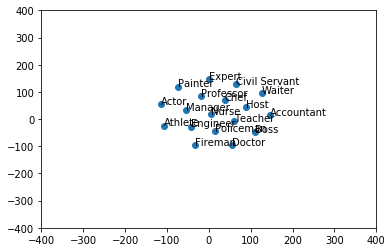

In [87]:
x_coords_N = Y_N[:, 0]
y_coords_N= Y_N[:, 1]
    # display scatter plot
plt.scatter(x_coords_N, y_coords_N)

for label, x, y in zip(occupations_E, x_coords_N, y_coords_N):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(-400, 400)
plt.ylim(-400, 400)
plt.show()

In [91]:
w_E= {}
for i,j in list(zip(E_male,E_female)):
    u_ij = np.add(normalized_word_vec[i],normalized_word_vec[j])/2
    w_E[i] = u_ij

In [92]:
v = {}
for i in w_E.keys():
    v_i = w_E[i] - sex_dim
    v[i] = v_i

In [5]:
import pickle

In [6]:
pickle_in = open('C:\\Users\\Luyang\\word_token2_new.pkl', 'rb')
word_token2= pickle.load(pickle_in)

Plot relevant plots

In [1]:
r1 = { '公务员': -0.3265282361648005, '运动员': -0.22815443811737557,'专家': -0.2017831620023863, '教师': -0.17865197763987417,
 '医生': -0.16977906220817812,'护士': -0.15148000840229817,'演员': -0.13875992899133271,'教授': -0.09597535726834319,
 '厨师': -0.09124838134311244,'主持人': -0.025885974680386337,'警察': -0.010055035036368953,'工程师': 0.0032060629272642888,
 '画家': 0.0159138568957997, '会计': 0.04101021214077875,'消防员': 0.0424485173265228,'老板': 0.05674994861312565,
 '经理': 0.0753093289626424,'服务员': 0.09075486501843874}


In [9]:
oc1 = pd.Series(r1,name = 'value1')
oc1.index_name = 'occupation'

In [8]:

r2 = {'会计': -0.093293587640945,'工程师':-0.0866985441111918,'公务员': -0.07126494996380793,'护士': -0.06869042163124318,
 '画家': -0.06295107448936757,'厨师': -0.052768907701232264,'医生': -0.046647891422724096,'经理': -0.02205940788869298,
 '服务员': -0.01856213897594154,'主持人':-0.009797422989108975,'教授':0.003596350281752237,'消防员': 0.022284945646990864,
'运动员': 0.02384832900904151,'演员': 0.05721990057577242,'老板': 0.06166039511942616,'专家':0.08008046542348946,'教师': 0.12602113783862437,
 '警察':0.20143777225636017}



In [14]:
oc2 = pd.Series(r2,name = 'value2')
oc2.index_name = 'occupation'

In [29]:

r3 ={'教授': -0.08351678315756018,
 '会计': -0.0831771938180007,
 '警察': -0.07819600478771387,
 '公务员': -0.05984410803856201,
 '工程师': -0.050367597444234816,
 '专家': -0.04725439630942189,
 '经理': -0.03500163842834474,
 '教师': -0.029059696914545973,
 '主持人': -0.023860619611287007,
 '护士': -0.02201635068615974,
 '老板': -0.012310468815511295,
 '画家': -0.0017146997818886234,
 '运动员': 0.004164995138988478,
 '演员': 0.009100480886129414,
 '医生': 0.011382554940491708,
 '厨师': 0.026638134575038948,
 '服务员': 0.04022330519039081,
 '消防员': 0.04567127000332011}


In [31]:
oc3 = pd.Series(r3,name = 'value3')
oc3.index_name = 'occupation'

In [38]:
r4 = {'教授':-0.09876246231934499,

 '画家': -0.08693576568130737,
 '公务员': -0.07996867763950229,
 '专家': -0.06805766418291812,
 '医生': -0.06450911669092543,
 '老板': -0.06196196673375988,
 '会计': -0.0615631616277251,
 '主持人': -0.05006056184253213,
 '警察': -0.04951131759124103,
 '工程师': -0.048970193236537965,
 '演员': -0.036382771011177,
 '厨师': -0.01655906666573357,
 '护士': -0.009565055224567201,
 '经理': 0.004802662315719058,
 '服务员': 0.007721067192957797,
 '教师': 0.02895231994909246,
 '运动员': 0.03719602348999776,
 '消防员': 0.07619419150816795}


In [39]:
oc4 = pd.Series(r4,name = 'value4')
oc4.index_name = 'occupation'

In [37]:

r5={'工程师': -0.12430983621239475,
 '老板': -0.10092146903292565,
 '会计': -0.0807586168438425,
 '消防员': -0.06000264735137098,
 '教授': -0.05686772694386322,
 '服务员': -0.05072527068732268,
 '经理': -0.04640165482578839,
 '画家': -0.04295315253819612,
 '教师': -0.03912478564927549,
 '厨师': -0.036515799987638965,
 '警察': -0.01986921323604811,
 '医生': -0.01264440365641817,
 '护士': 0.011145949408496059,
 '专家': 0.011958475764690321,
 '运动员': 0.040299289839638826,
 '演员': 0.04149631553179552,
 '主持人': 0.042120909264722145,
 '公务员': 0.08015382916467408}


In [44]:
oc5 = pd.Series(r5,name = 'value5')
oc5.index_name = 'occupation'

In [46]:
r6 = {'教师':-0.0928152523709714,
 '公务员': -0.07429670549433606,
 '运动员': -0.0598395028427824,
 '护士': -0.037658698953045334,
 '医生': -0.03660000052112582,
 '警察': -0.03588665029961154,
 '教授': -0.03199294155671384,
 '消防员': -0.02987352889833981,
 '演员': -0.02433474869567789,
 '专家': -0.022913329907760453,
 '工程师': -0.021398726968028137,
 '主持人': -0.010346510414773198,
 '画家': -0.0038092813244759993,
 '厨师': 0.0016144455911372459,
 '经理': 0.012789122208323242,
 '服务员': 0.023336188515069307,
 '会计': 0.03747415568151709,
 '老板': 0.044071608795725095}




In [47]:
oc6 = pd.Series(r6,name = 'value6')
oc6.index_name = 'occupation'

In [66]:
ind

['TEA',
 'PB',
 'ATH',
 'NUR',
 'DOC',
 'POL',
 'PRO',
 'FIR',
 'ACT',
 'EXP',
 'ENG',
 'HOS',
 'PAI',
 'CHE',
 'MAN',
 'WAI',
 'ACC',
 'BOS']

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

In [67]:
df =pd.concat([oc1, oc2,oc3,oc4,oc5,oc6], axis=1)

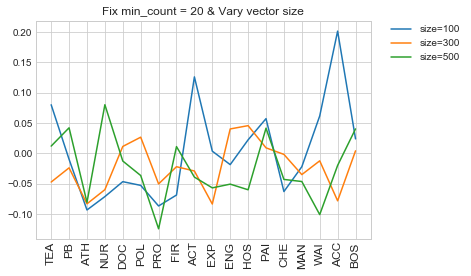

In [92]:
 plt.plot(ind,df['value2'],label = 'size=100')
 plt.plot(ind,df[['value3']],label = 'size=300')
 plt.plot(ind,df[['value5']],label = 'size=500')
plt.xticks(fontsize=12, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Fix min_count = 20 & Vary vector size')
plt.show()

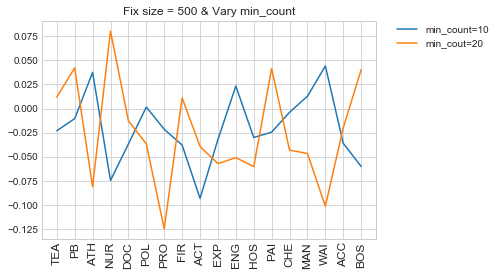

In [93]:
plt.plot(ind,df['value6'],label = 'min_count=10')
plt.plot(ind,df[['value5']],label = 'min_cout=20')
plt.xticks(fontsize=12, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Fix size = 500 & Vary min_count')
plt.show()

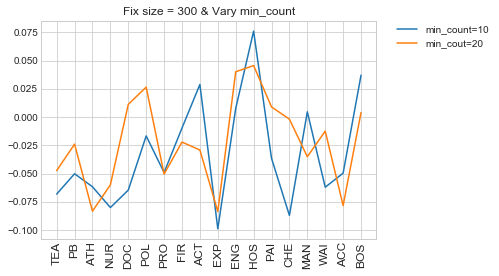

In [95]:
plt.plot(ind,df['value4'],label = 'min_count=10')
plt.plot(ind,df[['value3']],label = 'min_cout=20')
plt.xticks(fontsize=12, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Fix size = 300 & Vary min_count')
plt.show()

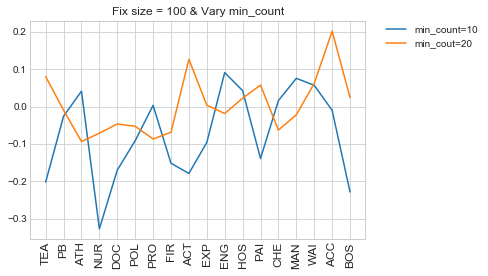

In [96]:
plt.plot(ind,df['value1'],label = 'min_count=10')
plt.plot(ind,df[['value2']],label = 'min_cout=20')
plt.xticks(fontsize=12, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Fix size = 100 & Vary min_count')
plt.show()